# Toy example estimation of Radon-Nikodym derivative

Equation (5) of the paper by Binkowski et al. explains that the Radon-Nikodym derivative $\frac{d \mathbb{Q}_y}{ \mathbb{P}_y^G}$ of the two domains exist under the assumptions they state. This derivative can also be seen as the ratio between the two distributions of the domains, and can be used to express the compensation for imbalance in the domains:

$\mathbb{E}_{Y \sim \mathbb{Q}_y}[D(Y)] = \mathbb{E}_{X \sim \mathbb{P}_x}[D(G(X)) \frac{d \mathbb{Q}_y}{ d\mathbb{P}_y^G}(G(X))]$

This expresses compensation for imbalance between the discriminator outputs, caused by the imbalance in the domain distributions. However, it does not necessarily have to be used for the imbalance in the discriminator outputs. It can be applied to any imbalance caused by the different domain distributions.

--

In other words, we are trying to study the situation where we don't deal with a discriminator but with any function, let it be $f$. This $f$ can be any function, e.g. identity, mean.... We try to compensate for imbalances in the two domains over which we compute the function:

$\mathbb{E}_{Y \sim \mathbb{Q}_y}[f(Y)] = \mathbb{E}_{X \sim \mathbb{P}_x}[f(G(X)) \frac{d \mathbb{Q}_y}{ d\mathbb{P}_y^G}(G(X))]$


--

The following toy example shows how we can use the Radon-Nikodym derivative for compensating the imbalance for the mean of the domains using $\bar{Y} = \bar{X}\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}$.

Let $X = [1, 1, 1, 1, 1, 1, 1, 0, 0]$, with mean $\bar{X} = 0.8$ and <br />
Let $Y = [1, 1, 0, 0, 0, 0, 0, 0, 0]$, with mean $\bar{Y} = 0.2$

Then $[1, 1, 0, 0, 0, 0, 0, 0, 0] = [1, 1, 1, 1, 1, 1, 1, 0, 0] \cdot \frac{d \mathbb{Q}_y}{d \mathbb{P}_x}(X)$, and <br />
$\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}(X) = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 4, 4]$

This can be interpreted as the ratio between means of the domains for each of the samples. In this example the ratio can be calculated. However, in more complex situations, for example with images, the Radon-Nykodym derivative $\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}$ is unknown and we may try to estimate it using a neural network $W$. This leads to the objective function

$\inf_{W \in \mathcal{W}} (\mathbb{E}_{X \sim \mathbb{P}_x} [D(G(X)) \cdot W(X)] - \mathbb{E}_{Y \sim \mathbb{Q}_y}[D(Y)])^2$

used by Binkowski et al. for compensation of distributions in the domains, using the discriminator output. Similarly, we can use such a network in our toy example.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch.unsqueeze(1).unsqueeze(1).cpu(), nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0.5)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def binary_data(size=(2**21, 1), ratio=0.5):
    
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio

    image_batch = torch.zeros(size)
    image_batch[idx] = 1
    
    return image_batch.clamp(0, 1).cuda()

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the binary data
    '''
    def __init__(self, ratio=0.5):

        self.ratio = ratio
        
        self.dataset = binary_data(ratio=self.ratio)
        
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 1))
        example_imgs[1] = 1
        
        return example_imgs

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

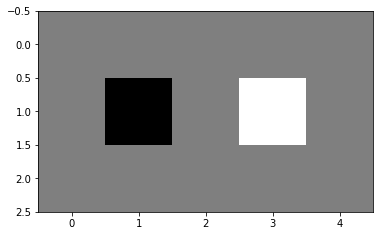

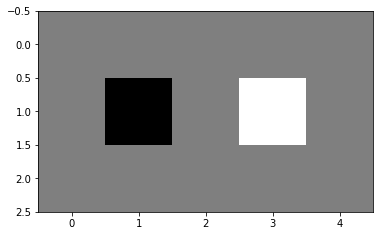

In [5]:
batch_size = 256

# Settings for domain A (red)
ratio_A = 0.2
dataset_A = ColorDataset(ratio=ratio_A)
dataloader_A = DataLoader(dataset_A, batch_size, shuffle=True)

# Settings for domain B (green)
ratio_B = 0.8
dataset_B = ColorDataset(ratio=ratio_B)
dataloader_B = DataLoader(dataset_B, batch_size, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

256


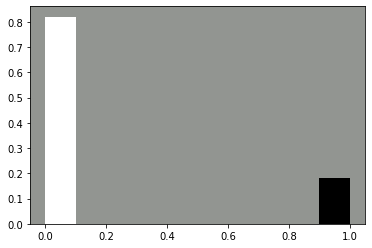

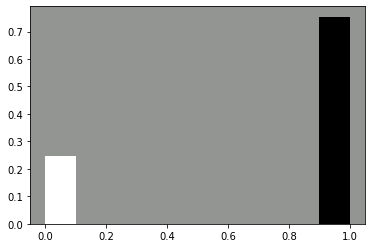

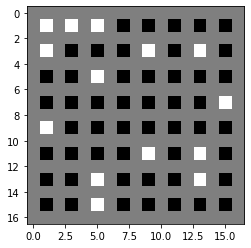

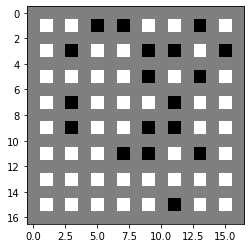

In [6]:
import cv2

def plot_hist(data):
    data = data.squeeze().cpu()
    plt.hist(data[data==1], weights=torch.ones(len(data[data==1]))/len(data), 
             color='black', bins=10, range= (0, 1))
    plt.hist(data[data==0], weights=torch.ones(len(data[data==0]))/len(data), 
             color='white', bins=10, range= (0, 1))
    plt.gca().set_facecolor('xkcd:gray')
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    print(len(data_A))
    plot_hist(data_A)
    plot_hist(data_B)
    
    visualize_img_batch(data_A[:64])
    visualize_img_batch(data_B[:64])
    break

In [7]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        self.fc2 = nn.Linear(1, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x))
        out = self.fc2(h1)
        return out

In [8]:
# Initialize the networks
weight_network = WeightNet().cuda()

# Initialize the optimizers
lr = 0.001
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)

losses_w = []

mean_A = []
mean_B = []

Lminusses = []
Lplusses = []

example_importances_A = []
example_importances_B = []

def weight_normalization(w):
    return w
#     return 0.5*(1 + w)

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):

        # The weighting process
        w = weight_network(real_A)
        v = weight_network(real_B)
    
        # The loss function --------------------------------------------------------------------------------
        
        # Using the means as objective function
        Lmin  = (real_A * weight_normalization(torch.sigmoid(w))).sum()
        Lplus = (real_B * weight_normalization(torch.sigmoid(-v))).sum()
        loss_w = (Lmin - Lplus)**2
        
        mean_A += [real_A.mean()]
        mean_B += [real_B.mean()]

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step()   

        # Store values --------------------------------------------------------------------------------------
        Lminusses += [Lmin.item()]
        Lplusses += [Lplus.item()]
        
        losses_w += [loss_w.item()]
        
        w_a = weight_normalization(torch.sigmoid(weight_network(dataset_A.example_imgs.cuda())))
        w_b = weight_normalization(torch.sigmoid(-weight_network(dataset_B.example_imgs.cuda())))
        example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list
        example_importances_B += [(w_b[0].item(), w_b[1].item())] # Store examples in a list

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            print('step', i, 'loss_w: ', loss_w.item())
            
        if i % 10000 == 0 and i != 0:
            break

step 0 loss_w:  5849.10205078125
step 500 loss_w:  1669.484130859375
step 1000 loss_w:  162.4525909423828
step 1500 loss_w:  10.184269905090332
step 2000 loss_w:  4.0692667961120605
step 2500 loss_w:  55.044429779052734


KeyboardInterrupt: 

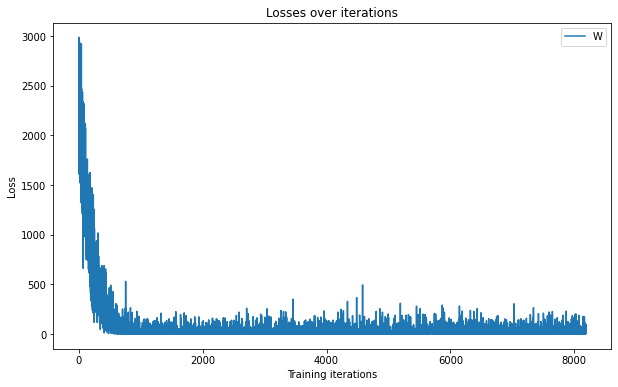

In [9]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_w)
plt.legend(['W'])
plt.show()

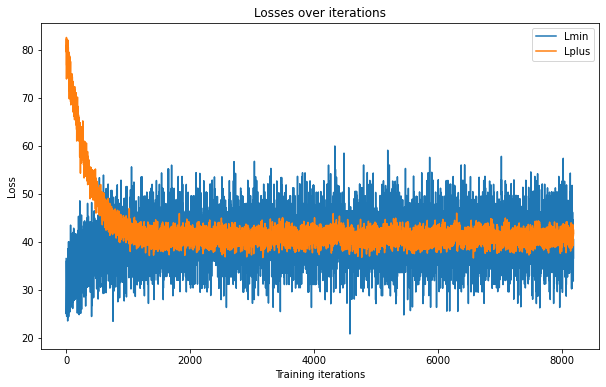

In [10]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(Lminusses)
plt.plot(Lplusses)
plt.legend(['Lmin', 'Lplus'])
plt.show()

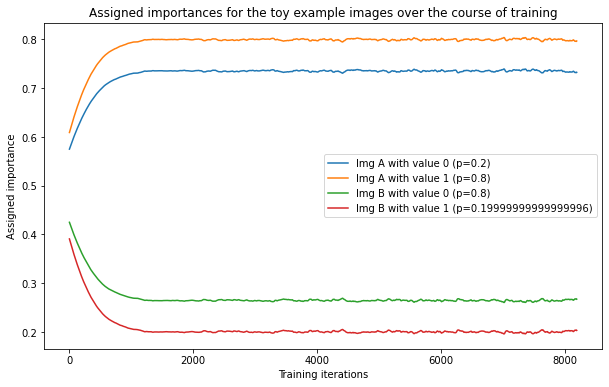

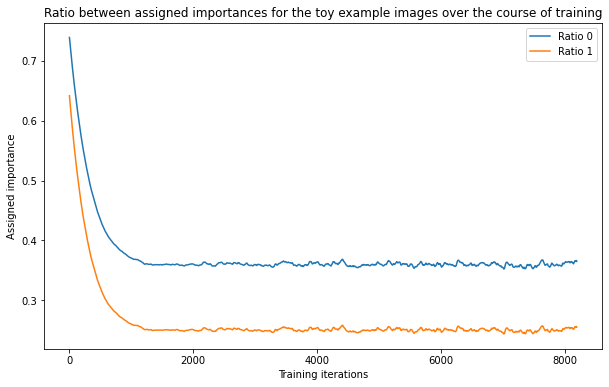

Ratio between assigned importances at iteration 8000: [0.36310006 0.25343956]
Actual ratio: 0.25


In [11]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.plot(example_importances_B)
plt.legend(['Img A with value {} (p={})'.format(0, ratio_A), 
            'Img A with value {} (p={})'.format(1, 1-ratio_A), 
            'Img B with value {} (p={})'.format(0, ratio_B), 
            'Img B with value {} (p={})'.format(1, 1-ratio_B)])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()

import numpy as np
plt.figure(figsize=(10,6))
plt.title('Ratio between assigned importances for the toy example images over the course of training')
ratio = list(np.array(example_importances_B) / np.array(example_importances_A))
plt.plot(ratio)
plt.legend(['Ratio 0', 
            'Ratio 1'])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()
print("Ratio between assigned importances at iteration 8000: " + str(ratio[8000]))
print("Actual ratio: " + str(ratio_A/ratio_B))

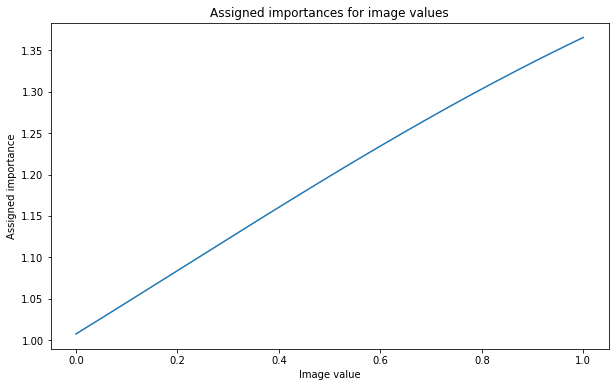

In [17]:
weights = weight_network(torch.linspace(0, 1, batch_size).view(-1,1).cuda()).cpu().detach().numpy()
plt.figure(figsize=(10,6))
plt.title('Assigned importances for image values')
plt.plot(torch.linspace(0, 1, batch_size), weights)
plt.ylabel('Assigned importance')
plt.xlabel('Image value')
plt.show()

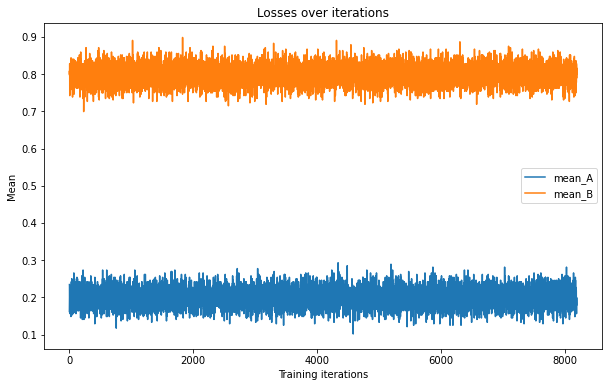

In [13]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Mean')
plt.plot(mean_A)
plt.plot(mean_B)
plt.legend(['mean_A', 'mean_B'])
plt.show()